## Import Packages

In [1]:
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import os.path
import seaborn as sns

from ipywidgets import widgets, Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider, Text
from IPython.display import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Class Definition

In [2]:
class PrepGsea:
    
    def __init__(self, gmt_file, expression_file, meta_file, output_dir, display_df_meta = False):
        
        self.gmt_file = gmt_file 
        self.expression_file = expression_file
        self.meta_file = meta_file
        self.output_dir = output_dir
        
        # check that these files exist
        if os.path.isfile(gmt_file) == False:
            print 'gmt_file does not exist'
            return
        if os.path.isfile(expression_file) == False:
            print 'expression_file does not exist'
            return
        if os.path.isfile(meta_file) == False:
            print 'meta_file does not exist'
            return        
        
        self.df_meta = pd.read_csv(meta_file)
        if display_df_meta == True: # recommended so that you can see your class and control choices
            print 'Meta DataFrame: '
            display(self.df_meta)
            
    def check_list(self, curr_list):
        first = curr_list[0]
        for obj in curr_list:
            if obj != first:
                return True
        return False
    
    def choose_comparison_col(self, sample_col_name = 'sample'):
        
        self.col_headers = list(self.df_meta)
        self.sample_col_name = sample_col_name
        
        self.col_headers = [header for header in self.col_headers if sample_col_name not in header.lower()]

        print 'Please choose a class from the following list.\n\n' \
                     + 'Do not reload cell after marking your choice.\n' \
                     + 'Mark your choice before proceding.'
        
        # generate pretty widget
        comparison_form_item_layout = Layout(
            display='flex',
            flex_flow='row',
            justify_content='space-between'
        )
        comparison_form_items = [
            Box([Label(value = 'Comparison options'), Dropdown(options = self.col_headers)], layout =  comparison_form_item_layout)
        ]
        comparison_form = Box(comparison_form_items, layout = Layout(
                display = 'flex',
                flex_flow = 'column',
                border = 'solid 2px',
                align_items = 'stretch',
                width = '50%'
        ))
        display(comparison_form)
        
        # save our widget where we can find it later
        self.comparison_col_button = comparison_form.children[0].children[1]
        
    def choose_two_classes(self):
        
        print 'Please specify the two classes you wish to compare for class \"' + str(self.comparison_col_button.value) + '\".\n\n' \
                     + 'Do not reload cell after indicating your choices.\n' \
                     + 'Indicate your choices before proceding.\n' \
                     + 'Reload this cell if the correct class isn\'t showing'

        # get class name from previous function call
        class_name = self.comparison_col_button.value
        
        # get all available options
        class_name = self.comparison_col_button.value
        class_options = list(set(self.df_meta[class_name]))
        
        # create pretty widget
        classes_form_item_layout = Layout(
            display='flex',
            flex_flow='row',
            justify_content='space-between'
        )
        classes_form_items = [
            Box([Label(value = class_name + ' class A'), Dropdown(options = class_options)], layout =  classes_form_item_layout),
            Box([Label(value = class_name + ' class B'), Dropdown(options = class_options)], layout = classes_form_item_layout)
        ]
        classes_form = Box(classes_form_items, layout = Layout(
                display = 'flex',
                flex_flow = 'column',
                border = 'solid 2px',
                align_items = 'stretch',
                width = '50%'
        ))
        display(classes_form)
        
        # save widgets where we can find them later (aka self.class_A_dropdown.value)
        self.class_A_textbox = classes_form.children[0].children[1] # class A
        self.class_B_textbox = classes_form.children[1].children[1] # class B
        
    def choose_controls(self):
        
        class_A = self.class_A_textbox.value
        class_B = self.class_B_textbox.value
        class_name = self.comparison_col_button.value
        
        print 'Please specify your control values for each of the following.\n\n' \
             + 'Do not reload cell after typing your choices.\n' \
             + 'Type your choices before proceding.'        
        
        # build widget without comparison column as an option
        if class_name in self.col_headers:
            self.col_headers.remove(class_name)
        
        # create pretty widget
        constants_form_item_layout = Layout(
            display='flex',
            flex_flow='row',
            justify_content='space-between'
        )
        constants_form_items = []
        for col in self.col_headers:
            options = list(set(self.df_meta[col]))
            constants_form_items.append(Box([Label(value = col), 
                                           Dropdown(options = options)], 
                                           layout =  constants_form_item_layout))
        constants_form = Box(constants_form_items, layout = Layout(
                display = 'flex',
                flex_flow = 'column',
                border = 'solid 2px',
                align_items = 'stretch',
                width = '50%'
        ))
        display(constants_form)

        # keep track of our widgets so that we can use them later
        self.controls_widget_array = []
        for child in constants_form.children:
            self.controls_widget_array.append(child.children[1])
                
    def filter_metafile(self):
        
        # remember user preferences
        class_A = self.class_A_textbox.value
        class_B = self.class_B_textbox.value
        class_name = self.comparison_col_button.value
        
        # check that comparison column choice is valid
        should_return = False
        if class_name not in list(self.df_meta):
            print '\"' + str(class_name) + '\" is not a valid column in your meta file'
            should_return = True
            
        if class_A not in list(self.df_meta[class_name]):
            print '\"' + str(class_A) + '\" is not a valid class name in your comparison column'
            should_return = True
            
        if class_B not in list(self.df_meta[class_name]):
            print '\"' + str(class_B) + '\" is not a valid class name in your comparison column'
            should_return = True
            
        if should_return == True:
            return
                
        # capture control values
        self.controls = {}
        for col, text in zip(self.col_headers, self.controls_widget_array):
            self.controls[col] = text.value
            
        print 'Filtering metafile by the following classes and controls:\n\n' \
        + 'class name: ' + str(class_name) + '\n' \
        + str(class_name) + ' value 1: ' + str(class_A) + '\n' \
        + str(class_name) + ' value 2: ' + str(class_B) + '\n\n' \
        + 'controls: '
        
        for k,v in self.controls.items():
            print str(k) + ': ' + str(v)
        
        print '\nPlease confirm that all the information above is correct.\n'
        
        # filter by control values
        for key, value in self.controls.iteritems(): 
            self.df_meta = self.df_meta[self.df_meta[key]==value]
        
        # filter by class name
        self.samp_to_class = self.df_meta[['Sample_name', class_name]]
        self.samp_to_class = self.samp_to_class[(self.samp_to_class[class_name] == class_A) | (self.samp_to_class[class_name] == class_B)]
        
        # pass the filter back to df_meta
        self.df_meta.index = self.df_meta['Sample_name']
        self.samp_to_class.index = self.samp_to_class['Sample_name']
        self.df_meta = self.df_meta.loc[self.samp_to_class.index]
        self.df_meta.index=range(len(self.df_meta))
        self.samp_to_class.index=range(len(self.samp_to_class))
        
        display(self.df_meta)
        
    def filter_expression_file(self, sample_col_name = 'Sample_name'):
        
        # remember user preferences
        class_A = self.class_A_textbox.value
        class_B = self.class_B_textbox.value
        class_name = self.comparison_col_button.value
            
        # check that comparison column choice is valid
        should_return = False
        if class_name not in list(self.df_meta):
            print '\"' + str(class_name) + '\" is not a valid column in your meta file'
            should_return = True
            
        if class_A not in list(self.df_meta[class_name]):
            print '\"' + str(class_A) + '\" is not a valid class name in your comparison column'
            should_return = True
            
        if class_B not in list(self.df_meta[class_name]):
            print '\"' + str(class_B) + '\" is not a valid class name in your comparison column'
            should_return = True
            
        if should_return == True:
            return

        # load and display expression file
        self.df_expression = pd.read_table(self.expression_file, index_col='Unnamed: 0')
        focal_samples = list(self.df_expression)  # header

        # filter netafile by samples
        self.df_meta = self.df_meta[self.df_meta[sample_col_name].isin(focal_samples)]

        # filter metafile by controls
        for key, value in self.controls.iteritems(): 
            self.df_meta = self.df_meta[self.df_meta[key]==value]

        print "Expression file before filtering: " + str(self.df_expression.shape)
        display(self.df_expression.head())
        print "\nFiltered meta file: " + str(self.df_meta.shape)
        display(self.df_meta)

        # extract only the COLUMNS with sample_name and class name
        self.samp_to_class = self.df_meta[['Sample_name', class_name]]

        # only keep the rows with class_A and class_B
        self.samp_to_class = self.samp_to_class[(self.samp_to_class[class_name] == class_A) | (self.samp_to_class[class_name] == class_B)]

        # Filter expression file
        real_focal_samples = self.samp_to_class['Sample_name'].tolist()
        self.df_expression = self.df_expression[real_focal_samples]

        cap_gene = [str(g).upper() for g in self.df_expression.index.tolist()] # cap the genes
        self.df_expression['Name'] = cap_gene                                  # create a new column
        self.df_expression = self.df_expression[['Name'] + real_focal_samples] # put the 'Name' column at front
        self.df_expression.index = range(0,len(self.df_expression))                 # number the rows

        print "\nFiltered expression file: " + str(self.df_expression.shape)
        display(self.df_expression.head())

        self.cls_list = self.samp_to_class[class_name].tolist()
        if self.check_list(self.cls_list) == False:
            print '\nWarning: Your class column contains only one value. It should contain two. GSEA may not work under these circumstances.'
            
    def call_gsea(self,
              method = 'log2_ratio_of_classes',
              processes = 4,    ## 1 is default
              format = 'png',
              permutation_num = 100, # reduce number to speed up test
              weighted_score_type = 1,  # default: 1
             ):
    
        print "This may take a few minutes."
        self.gs_res = gp.gsea(data = self.df_expression, 
                              gene_sets = self.gmt_file,
                              cls = self.cls_list, 
                              permutation_num = permutation_num,
                              weighted_score_type = weighted_score_type,
                              outdir = self.output_dir,
                              method = method,
                              processes = processes,    ## 1 is default
                              format = format)

        #access the dataframe results throught res2d attribute
        return self.gs_res.res2d.head()
    
    def plot_gsea(self, style_content = 'ggplot', top = 20, y = 'fdr', x = 'Term', fontsize = 8):
        gsea_results = self.gs_res.res2d
        with plt.style.context(style_content):
            gsea_results = gsea_results.reset_index()
            gsea_results.head(top).plot.barh(y = y, x = x, fontsize = fontsize)
            
    def plot_individual_pathway_heatmap(self, focal_term):
        
        # select a focal term and plot it by samples
        focal_genes = self.gs_res.res2d.loc[focal_term]['genes'].split(',')

        # only plot max 50 genes
        if len(focal_genes)>50:
            if self.gs_res.res2d.loc[focal_term]['nes']>0:
                focal_genes = focal_genes[:50]
            else:
                focal_genes = focal_genes[-50:]


        self.df_meta.index=self.df_meta['Sample_name']

        cols_to_plot = self.df_meta.index.tolist()

        classA_color='#96ceb4'
        classB_color='#ffeead'
        classA = self.class_A_textbox.value
        classB = self.class_B_textbox.value
        col_colors = [classA_color if self.df_meta.loc[c][self.comparison_col_button.value]==classA else classB_color for c in cols_to_plot]
        col_colors = pd.Series(col_colors,index=cols_to_plot)

        col_colors = col_colors.sort_values()
        cols_to_plot = col_colors.index.tolist() # sort by condition


        self.df_expression.index = self.df_expression['Name']
        E_samps_plot = self.df_expression.loc[focal_genes][cols_to_plot]
        
        
        idx_cond1 = col_colors[col_colors==classA_color].index.tolist() # sort by difference in conditions
        idx_cond2 = col_colors[col_colors==classB_color].index.tolist() # sort by difference in conditions
        E_samps_norm = E_samps_plot.T.subtract(E_samps_plot.mean(axis=1)).divide(E_samps_plot.std(axis=1)).T # standardize E_samps_plot
        idx_sort = (E_samps_norm[idx_cond1].mean(axis=1)-E_samps_norm[idx_cond2].mean(axis=1)).sort_values().index.tolist()
        E_samps_norm = E_samps_norm.loc[idx_sort]

        g=sns.clustermap(E_samps_norm,cmap='bwr',vmin=-2,vmax=2,
                      method='ward',figsize=(4,12),z_score=0,col_colors=col_colors,col_cluster=False,row_cluster=False)

        g.data2d.head()
        tmp = g.ax_heatmap.set_yticks(np.arange(len(focal_genes))+.5)
        tmp = g.ax_heatmap.set_yticklabels(g.data2d.index.tolist())

        plt.sca(g.ax_heatmap)
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=14)

        # make a new directory to save these figs
        if not os.path.isdir(self.output_dir+'/selected_heatmaps'):
            os.mkdir(self.output_dir+'/selected_heatmaps')

        plt.annotate(s=classA,xy=(0.05,0.05),xytext=(0.25, 0.805),fontsize=14,textcoords='figure fraction')
        plt.annotate(s=classB,xy=(0.05,0.05),xytext=(0.45, 0.805),fontsize=14,textcoords='figure fraction')
        plt.title(focal_term,y=1.08)
        plt.savefig(self.output_dir+'/selected_heatmaps/'+focal_term+'_clustermap.pdf',dpi=300,bbox_inches='tight')

        self.df_expression.index=range(len(self.df_expression)) # put the index back
        self.df_meta.index=range(len(self.df_meta))


## User Preferences for Metafile Filtering

In [3]:
gsea_prepper = PrepGsea(gmt_file = '../../gseapy_databases/h.all.v6.1.symbols.gmt',
                        expression_file = '../../gseapy_databases/RNA_cpm_all_samples.tsv',
                        #expression_file = '../../gseapy_databases/exp_ALCvsCHOWinNTinAlbCre.tsv',
                        meta_file = '../../gseapy_databases/dHEP_metadata.csv',
                        output_dir = '/../../gseapy_databases/mouse_liver_output')

In [4]:
gsea_prepper.choose_comparison_col("sample")

Please choose a class from the following list.

Do not reload cell after marking your choice.
Mark your choice before proceding.


Box(children=(Box(children=(Label(value=u'Comparison options'), Dropdown(options=('mouse genotype', 'short_genotype', 'Model', 'Treatment', 'Tissue'), value='mouse genotype')), layout=Layout(display=u'flex', flex_flow=u'row', justify_content=u'space-between')),), layout=Layout(align_items=u'stretch', border=u'solid 2px', display=u'flex', flex_flow=u'column', width=u'50%'))

In [5]:
# Please choose the following:

# Tissue class A: Liver
# Tissue class B: liver_tumor

gsea_prepper.choose_two_classes() # text must match exactly what's in your meta dataframe

Please specify the two classes you wish to compare for class "Tissue".

Do not reload cell after indicating your choices.
Indicate your choices before proceding.
Reload this cell if the correct class isn't showing


Box(children=(Box(children=(Label(value=u'Tissue class A'), Dropdown(options=('Liver', 'liver_tumor'), value='Liver')), layout=Layout(display=u'flex', flex_flow=u'row', justify_content=u'space-between')), Box(children=(Label(value=u'Tissue class B'), Dropdown(options=('Liver', 'liver_tumor'), value='Liver')), layout=Layout(display=u'flex', flex_flow=u'row', justify_content=u'space-between'))), layout=Layout(align_items=u'stretch', border=u'solid 2px', display=u'flex', flex_flow=u'column', width=u'50%'))

In [12]:
# Please choose the following:

# mouse genotype: Alb-Cre;IL-17RA-flox/flox
# short_genotype: AlbCre_IL17RA_floxflox
# Model: DEN
# Treatment: DEN_HFD_alcohol

gsea_prepper.choose_controls() # text must match exactly what's in your meta dataframe

Please specify your control values for each of the following.

Do not reload cell after typing your choices.
Type your choices before proceding.


Box(children=(Box(children=(Label(value=u'mouse genotype'), Dropdown(options=('Alb-Cre;IL-17RA-flox/flox',), value='Alb-Cre;IL-17RA-flox/flox')), layout=Layout(display=u'flex', flex_flow=u'row', justify_content=u'space-between')), Box(children=(Label(value=u'short_genotype'), Dropdown(options=('AlbCre_IL17RA_floxflox',), value='AlbCre_IL17RA_floxflox')), layout=Layout(display=u'flex', flex_flow=u'row', justify_content=u'space-between')), Box(children=(Label(value=u'Model'), Dropdown(options=('DEN ',), value='DEN ')), layout=Layout(display=u'flex', flex_flow=u'row', justify_content=u'space-between')), Box(children=(Label(value=u'Treatment'), Dropdown(options=('DEN_HFD_alcohol',), value='DEN_HFD_alcohol')), layout=Layout(display=u'flex', flex_flow=u'row', justify_content=u'space-between'))), layout=Layout(align_items=u'stretch', border=u'solid 2px', display=u'flex', flex_flow=u'column', width=u'50%'))

In [7]:
gsea_prepper.filter_metafile()

Filtering metafile by the following classes and controls:

class name: Tissue
Tissue value 1: Liver
Tissue value 2: liver_tumor

controls: 
mouse genotype: Alb-Cre;IL-17RA-flox/flox
short_genotype: AlbCre_IL17RA_floxflox
Model: DEN 
Treatment: DEN_HFD_alcohol

Please confirm that all the information above is correct.



,Sample_name,Sample_Name2,mouse genotype,short_genotype,Model,Treatment,Tissue
0,dHEP_518_A_NT,dHEP-518-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
1,dHEP_520_A_NT,dHEP-520-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
2,dHEP_549_A_NT,dHEP-549-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
3,dHEP_550_A_NT,dHEP-550-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
4,dHEP_518_A_T1,dHEP-518-A-T1,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
5,dHEP_520_A_T,dHEP-520-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
6,dHEP_549_A_T,dHEP-549-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
7,dHEP_550_A_T,dHEP-550-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor


## Filter Expression File

In [8]:
gsea_prepper.filter_expression_file()

Expression file before filtering: (22187, 30)


,dHEP_549_A_T,dHEP_520_A_NT,dHEP_178_NI,F_F_167_NC_T,dHEP_550_A_NT,F_F_158_NC_NT,dHEP_549_A_NT,dHEP_520_A_T,F_F_169_NC_T,F_F_503_A_T1,...,dHEP_164_NC_NT,F_F_523_A_T1,F_F_184_NI,dHEP_155_NC_NT,F_F_159_NC_NT,dHEP_165_NC_T,dHEP_155_NC_T,F_F_168_NC_T,F_F_595_A_T,F_F_581_A_NT
Gnai3,121.519560,89.035979,94.557437,113.223446,98.230254,111.136707,97.474351,132.836892,109.328840,114.096305,...,113.769663,132.891660,109.728700,106.096154,103.304758,192.471416,153.176144,183.460817,152.620839,108.366033
NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cdc45,1.958903,1.673062,1.196930,2.630385,1.766455,1.086912,0.898758,2.300206,1.993288,1.984284,...,2.222064,1.612585,0.693510,1.687041,1.777031,1.688346,4.976438,4.123100,1.531535,1.943865
NaN,0.067548,0.072742,0.108812,0.233812,0.153605,0.000000,0.000000,0.287526,0.241611,0.631363,...,0.000000,0.293197,0.077057,0.000000,0.000000,0.135068,0.238221,0.056104,0.000000,0.065916
Apoh,1484.443494,1381.221548,1823.576617,1170.813440,1223.001220,1827.370055,1292.413480,886.585618,1267.127294,1078.638506,...,1497.374679,1145.375110,1898.753434,1567.636285,1727.570680,1453.395562,627.533836,1003.480178,1232.619699,1349.697628



Filtered meta file: (8, 7)


,Sample_name,Sample_Name2,mouse genotype,short_genotype,Model,Treatment,Tissue
0,dHEP_518_A_NT,dHEP-518-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
1,dHEP_520_A_NT,dHEP-520-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
2,dHEP_549_A_NT,dHEP-549-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
3,dHEP_550_A_NT,dHEP-550-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
4,dHEP_518_A_T1,dHEP-518-A-T1,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
5,dHEP_520_A_T,dHEP-520-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
6,dHEP_549_A_T,dHEP-549-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
7,dHEP_550_A_T,dHEP-550-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor



Filtered expression file: (22187, 9)


,Name,dHEP_518_A_NT,dHEP_520_A_NT,dHEP_549_A_NT,dHEP_550_A_NT,dHEP_518_A_T1,dHEP_520_A_T,dHEP_549_A_T,dHEP_550_A_T
0,GNAI3,89.013791,89.035979,97.474351,98.230254,109.496950,132.836892,121.519560,230.577450
1,NAN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,CDC45,2.455007,1.673062,0.898758,1.766455,1.489754,2.300206,1.958903,6.451114
3,NAN,0.000000,0.072742,0.000000,0.153605,0.165528,0.287526,0.067548,0.199519
4,APOH,1312.319871,1381.221548,1292.413480,1223.001220,1304.197234,886.585618,1484.443494,1383.930242


In [9]:
gsea_prepper.call_gsea(method = 'log2_ratio_of_classes',
          processes = 4,
          format = 'png',
          permutation_num = 100,
          weighted_score_type = 1)

2018-05-02 10:30:03,479 Warning: dropping duplicated gene names, only keep the first values


This may take a few minutes.


,es,nes,pval,fdr,geneset_size,matched_size,genes
Term,,,,,,,
HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.585090,-1.772362,0.0,0.0,200,180,"G0S2,LAMB3,PFKFB3,NFIL3,GEM,KLF2,SPSB1,SPHK1,G..."
HALLMARK_ANGIOGENESIS,-0.723299,-1.792728,0.0,0.0,36,32,"NRP1,FGFR1,VTN,APOH,VEGFA,THBD,SLCO2A1,LUM,LRP..."
HALLMARK_MTORC1_SIGNALING,-0.588493,-1.793189,0.0,0.0,200,191,"SRD5A1,NFIL3,IGFBP5,PDK1,ME1,SORD,GLRX,SHMT2,C..."
HALLMARK_BILE_ACID_METABOLISM,0.488698,1.963228,0.0,0.0,112,103,"CYP7B1,CYP46A1,CYP8B1,RETSAT,CYP27A1,KLF1,CYP7..."
HALLMARK_CHOLESTEROL_HOMEOSTASIS,-0.686419,-1.868008,0.0,0.0,74,68,"GNAI1,ADH4,NFIL3,ETHE1,ECH1,CPEB2,PPARG,ABCA2,..."


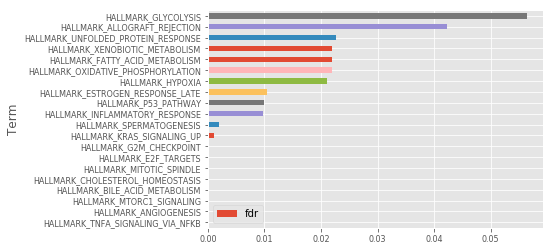

In [10]:
gsea_prepper.plot_gsea(style_content = 'ggplot', top = 20, y = 'fdr', x = 'Term', fontsize = 8)

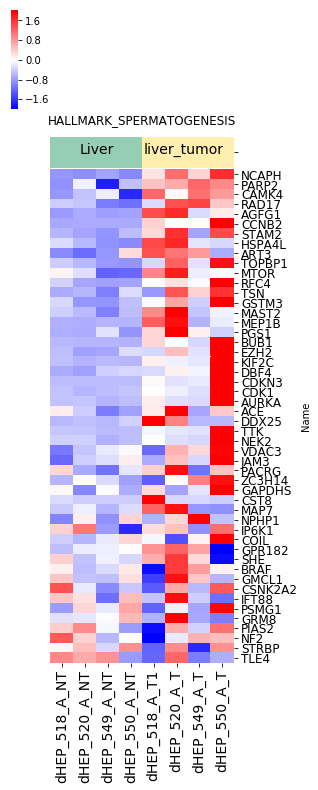

In [11]:
gsea_prepper.plot_individual_pathway_heatmap('HALLMARK_SPERMATOGENESIS')